In [50]:
import warnings
import numpy as np
import math, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec
from shapely.geometry import LineString

from local_utils import dst_bearing, rl_inverse, draw, tdraw, intersect, rad_magic, rad_back_magic, polar_logspiral, rect_logspiral, eval_a_logspiral

In [188]:
class NodeRegion():

    s = 100

    def __init__(self, root=None, leaf=None, params_r=None, params_l=None, crds=None, b=None, fake_uplim=None):
        """Constructor"""
        self.thmax = {'right': np.pi, 'left': np.pi} if fake_uplim is None else fake_uplim

        self.root = (0,0) if root is None else root
        self.leaf = (0,0) if leaf is None else leaf

        self.dst, self.ang = dst_bearing(self.root, self.leaf)
        self.th = np.linspace(0, np.pi, self.s)
        self.params = None
        if params_r is not None and params_l is not None:
            thr = np.linspace(0, self.thmax['right'], self.s)
            thl = np.linspace(0, self.thmax['left'], self.s)
            # надо вычитать из пи разницу угла родительской спирали и текущей спирали перед вычислениями
            rr = polar_logspiral(params_r["a"], params_r["b"], thr)
            rl = polar_logspiral(params_l["a"], params_l["b"], thl)
            # rr = params_r["r"]
            # rl = params_l["r"]
            self.params = {
                "right": {"a": params_r["a"], "b": params_r["b"], "r": rr},
                "left": {"a": params_l["a"], "b": params_l["b"], "r": rl}
            }
            self.crds = {
                "right_xy": rect_logspiral(rr, self.th, self.ang, "right"),
                "left_xy": rect_logspiral(rl, self.th, self.ang, "left")
            }
        else:
            if b is None:
                raise ValueError("params_r, params_l, b are None. Pass them correctly")
            else:
                a = eval_a_logspiral(self.dst, b)
                r = polar_logspiral(a, b, self.th)
                params = {"a": a, "b": b, "r": r}
                self.params = {
                    "right": params,
                    "left": params
                }
                self.crds = {
                    "right_xy": rect_logspiral(r, self.th, self.ang, "right"),
                    "left_xy": rect_logspiral(r, self.th, self.ang, "left")
                }



    def crop(self, tp, upperlimit_xy=None, lowerlimit_xy=None, inplace=False):
        '''
        Вырезание кривой между точками
        return: params, crds NOT INPLACE ONLY
        '''
        # Проверки и определения
        assert tp in ('right', 'left'), "tp must be assigned"

        if inplace:
            self.tp = tp
            self.upperlimit_xy = self.leaf if upperlimit_xy is None else upperlimit_xy
            self.lowerlimit_xy = self.root if lowerlimit_xy is None else lowerlimit_xy
        thmax = self.thmax[tp]
        # Расчет
        sign = 1 if tp == 'right' else -1

        if upperlimit_xy is not None:
            uplt_th_ang = np.arctan2(upperlimit_xy[1]-self.root[1], upperlimit_xy[0]-self.root[0])

            # this if statement handles situation, when intersection is above zero and leaf is below zero
            # withput this statemnt ~limit_th calculation is incorrect
            if np.sign(uplt_th_ang) == -1 and np.sign(self.ang) == 1:
                uplt_th_ang = rad_back_magic(uplt_th_ang)

            upperlimit_th = thmax - sign*(self.ang - uplt_th_ang)
        else:
            upperlimit_th = thmax

        if lowerlimit_xy is not None:
            lwlt_th_ang = np.arctan2(lowerlimit_xy[1]-self.root[1], lowerlimit_xy[0]-self.root[0])

            # this if statement handles situation, when intersection is above zero and leaf is below zero
            # withput this statemnt ~limit_th calculation is incorrect
            if np.sign(lwlt_th_ang) == -1 and np.sign(self.ang) == 1:
                lwlt_th_ang = rad_back_magic(lwlt_th_ang)

            lowerlimit_th = thmax - sign*(self.ang - lwlt_th_ang)
        else:
            lowerlimit_th = 0

        # Запись результата inplace
        if inplace:
            self.th = np.linspace(lowerlimit_th, upperlimit_th, self.s)

            a = self.params[tp]['a']
            b = self.params[tp]['b']
            r = polar_logspiral(a, b, self.th)
            self.params = {
                self.tp: {"a": a, "b": b, "r": r}
            }
            self.crds = {
                f"{tp}_xy": rect_logspiral(r, self.th, self.ang, tp)
            }
        else:
            th = np.linspace(lowerlimit_th, upperlimit_th, self.s)
            a = self.params[tp]['a']
            b = self.params[tp]['b']
            r = polar_logspiral(a, b, self.th)
            params = {
                tp: {"a": a, "b": b, "r": r}
            }
            return params, upperlimit_th
        
    
    def plot(self, ax1=None, ax2=None, polar = True, **kwargs):
        # Отрисовка кривой внутри всей области определения
        fig = plt.figure(1,(15,15)) if ax1 is None else None
        if polar:
            ax1 = fig.add_subplot(221,polar=True) if ax1 is None else ax1
        ax2 = fig.add_subplot(222,polar=False) if ax2 is None else ax2
        
        xr,yr = self.crds["right_xy"]
        xl,yl = self.crds["left_xy"]
        
        rr = self.params['right']['r']
        rl = self.params['left']['r']
        
        if polar:
            ax1.plot(self.th, rr, "-c")
            ax1.plot(-self.th, rl, "-m")
        ax2.plot(xr,yr, "-c", **kwargs)
        ax2.plot(xl,yl, "-m", **kwargs)
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)


    def tplot(self, ax1=None, ax2=None, polar = True, limdraw=False):
        # Отрисовка кривой внутри обрезанной области определения
        fig = plt.figure(1,(15,15)) if ax1 is None else None
        if polar:
            ax1 = fig.add_subplot(221,polar=True) if ax1 is None else ax1
        ax2 = fig.add_subplot(222,polar=False) if ax2 is None else ax2

        x,y = self.crds[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        if polar:
            ax1.plot(self.th*sign, self.params[self.tp]["r"], f"-{color}")
        
        ax2.plot(x,y, f"-{color}")

        if limdraw:
            ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
            ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")

        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)

    def validate_crds(crds):
        """if crds.keys() are not 'right_xy' or 'left_xy', raises KeyError
        if any of crds.values() is not sequence, raises TypeError
        """
        if not all(list(map(lambda x: x == 'right_xy' or x == 'left_xy', list(crds.keys())))) == True:
            raise KeyError(f"{crds.keys()} are invalid keys. Keys must be ('right_xy', 'left_xy')")
        
        if not all(list(map(lambda x: type(x) in (tuple, list), crds.values()))) == True:
            raise TypeError(f"{crds.values()} are invalid values. Coordinates must be tuples or lists")


    def get_dst2(self):
        '''NB! Read comments inside! still counts dst between lowerlimit and upperlimit'''
        warnings.warn("get_dst2 still counts dst between lowerlimit and upperlimit") # NB!!!
        try:
            return np.sqrt((self.upperlimit_xy[0]-self.lowerlimit_xy[0])**2 + (self.upperlimit_xy[1]-self.lowerlimit_xy[1])**2)
        except AttributeError:
            return self.dst


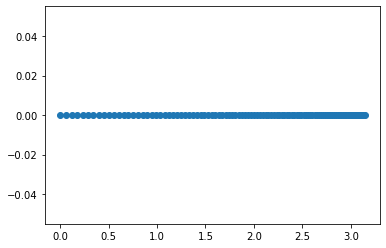

In [223]:
a = np.geomspace(-np.pi-1, -1, 100) + 1 + np.pi
y = np.zeros(100)
plt.plot(a, y, "o")

In [157]:
# curve = NodeRegion((0,0), (0,20), b=1.9)
# curve.plot()

In [158]:
# class FlowTree():

#     def __init__(self, root=None, leaves=None):
#         self.root = (0,0) if root is None else root
#         self.leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)] if leaves is None else leaves

#     def build():
#         pass
    
#     def draw():
#         pass
    
#     def to_geometry_query():
#         pass

In [159]:
log = []
class FlowTreeBuilder():

    def __init__(self, root=(0,0), leaves=[ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)], b=1.9, vbs=False):
        self.root = root
        self.leaves = leaves
        self.b = b
        self.vbs = vbs
        self.arcs = self.main_exec(self.root, self.leaves, self.b)
        
    
    def main_exec(self, root, leaves, b):
        
        fig = plt.figure(1,(20,10), facecolor='gray')
        spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 2, 2], wspace=0.5,
                         hspace=0.5)

        ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
        ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')
        ax3 = fig.add_subplot(spec[2],polar=False, facecolor='white')

        never_activated = [NodeRegion(b=b, root=root, leaf=leaf) for leaf in leaves]

        draw(never_activated, ax1=ax1, ax2=ax2, polar=False)

        ax3.set_xlim(ax2.get_xlim())
        ax3.set_ylim(ax2.get_ylim())

        active = []
        result_curves = []

        C = max(list(map(lambda x: x.dst, never_activated)))
        C -= 0.01
        while C > 0:
            # creating queue
            active = list(filter(lambda x: x.get_dst2() > C, never_activated))

            # intersecting
            intersections = []
            interm = active.copy()
            for curve in active:
                interm.remove(curve)
                for c in interm:
                    # NOT HANDLES NONE OUTPUT FROM INTERSECT
                    intersections.append(intersect(curve, c, plotting=True, ax=ax2))
            try:
                del c, interm
            except UnboundLocalError:
                del interm

            # filtering intersections
            for join_position in filter(lambda x: x["dst"] > C, intersections):
                print(join_position['dst'])
                lowerlimit_xy, tp1 = join_position["position_type"]
                tp2 = rl_inverse(tp1)
                curve1, curve2 = join_position["curves"]
                
                params1, uplim_th_1 = curve1.crop(tp=tp1, upperlimit_xy=lowerlimit_xy)
                params2, uplim_th_2 = curve2.crop(tp=tp2, upperlimit_xy=lowerlimit_xy)

                fake_uplim = {
                    tp1: uplim_th_1,
                    tp2: uplim_th_2
                    }

                params_l = list(filter(lambda x: "left" in list(x.keys()), (params1, params2)))[0]
                params_r = list(filter(lambda x: "right" in list(x.keys()), (params1, params2)))[0]

                terminal_from_joinpoint = NodeRegion(root=self.root, 
                leaf=tuple(lowerlimit_xy.tolist()), 
                params_l=params_l['left'], 
                params_r=params_r['right'],
                fake_uplim=fake_uplim)

                curve1.crop(tp=tp1, lowerlimit_xy=lowerlimit_xy, inplace=True)
                curve2.crop(tp=tp2, lowerlimit_xy=lowerlimit_xy, inplace=True)
                
                
                
                log.append(copy.copy(terminal_from_joinpoint))
                for i in (curve1, curve2):
                    never_activated.remove(i)
                    result_curves.append(i)
                never_activated.append(terminal_from_joinpoint)
                
            

            C-=0.01
        
        tdraw(result_curves, ax1=ax1, ax2=ax3, polar=False)

        return


C:\Users\Pinigin\AppData\Local\Temp/ipykernel_5900/1677787182.py:178: UserWarning: get_dst2 still counts dst between lowerlimit and upperlimit
  warnings.warn("get_dst2 still counts dst between lowerlimit and upperlimit") # NB!!!
c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:119: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  inter_crds0 = np.array(LineString(intersection).coords)
C:\Users\Pinigin\anaconda3\envs\spat_a_course\lib\site-packages\shapely\geometry\linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:137: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. C

18.746534454094093
14.995763986973365
13.903004742834964
11.297633122491018
5.318480266041525
2.601394227556768
0.6806880763284974


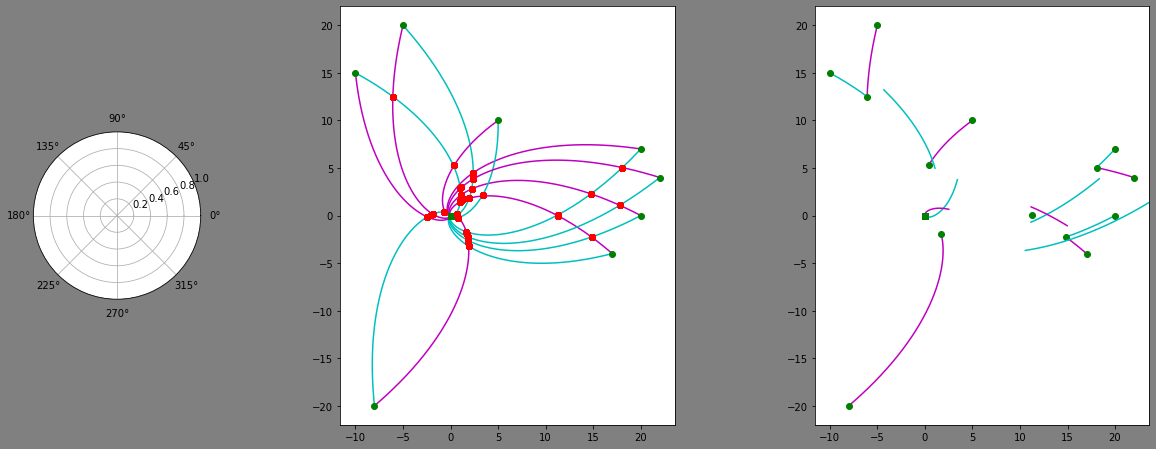

In [73]:
leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20), (20, 0), (5, 10), (22, 4)]
expl = FlowTreeBuilder(b=1.9, leaves=leaves, vbs=False)

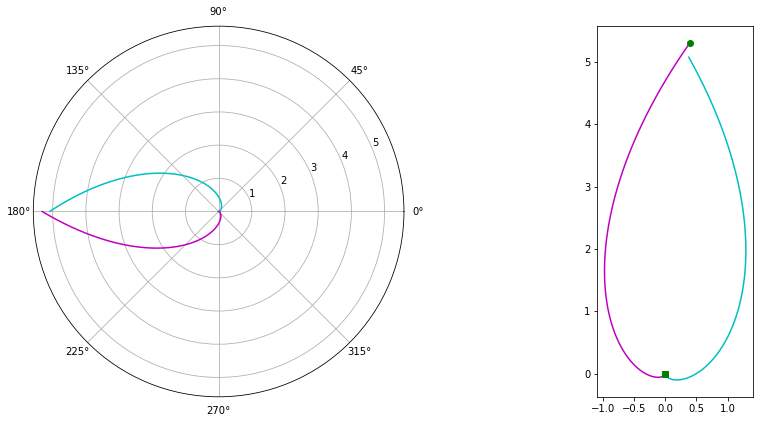

In [75]:
log[4].plot()

In [139]:
import random as rand

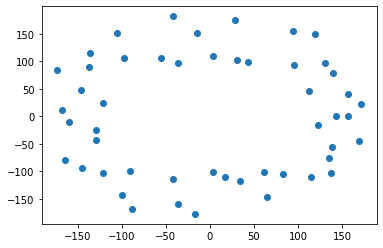

In [10]:
#generate some data
leaves = []

r = 100
phi = np.linspace(0, np.pi*2, 50)
noise = np.random.rand(len(phi))*100
r = r+noise
x = r*np.cos(phi)
y = r*np.sin(phi)
for i in range(len(phi)-1):
    leaves.append((x[i], y[i]))

plt.scatter(x, y)

In [16]:
bias = np.array((193.980769230769, -195.706730769231))
leaves = []
l_prep = [(244.461538461538,-50.7259615384615),
(168.134615384615, -40.2259615384615),
(141.884615384615, -81.4182692307691),
(76.0576923076923, -37.3990384615384),
(216.899038461538, -111.605769230769),
(304.129807692308, -88.8894230769231),
(322.201923076923, -130.6875),
(283.9375, -184.701923076923),
(301.302884615385, -202.471153846154),
(304.9375, -254.971153846154),
(210.841346153846, -279.605769230769),
(185.197115384616, -244.471153846154),
(172.879807692308, -314.538461538462),
(109.879807692308, -310.096153846154),
(46.4759615384617, -278.596153846154),
(59.3990384615386, -214.990384615385),
(114.927884615385, -204.692307692308),
(21.8413461538463, -177.432692307692),
(36.5817307692309, -130.586538461539),
(56.3701923076924, -102.317307692308)]

for i in l_prep:
    leaves.append(list(np.array(i) - bias))

In [27]:
# leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20), (20, 0), (5, 10), (22, 4)]
leaves = dataset
# leaves = [ (10, 8), (11, 3), (12, 1), (10.5, -3.5), (11.8, -6)]
expl = FlowTreeBuilder(b=1.9, leaves=leaves, vbs=False)

AttributeError: 'tuple' object has no attribute 'dst'

In [18]:
dataset = [(110.60289476284164, 0.0),
 (172.66269590402504, 38.00593334790393),
 (160.04780458535853, 74.04599928279603),
 (91.28819245356952, 69.39547975534474),
 (84.53031269794627, 99.51677748032657),
 (60.82883221325307, 114.73534898240658),
 (44.21192450783797, 159.23696070102386),
 (9.237648714392932, 170.37840524965335),
 (-16.7481641066041, 102.15928160389913),
 (-46.50537127325378, 116.71968057336491),
 (-77.27938662754069, 113.97856801033778),
 (-102.55266333593273, 97.14304271129762),
 (-114.95662921751178, 69.16710888299222),
 (-120.8788321280685, 40.72882066269916),
 (-178.2827001181997, 19.38941210325078),
 (-154.36600909848062, -16.788315204785544),
 (-140.3941738848047, -47.30430489420864),
 (-108.0101151223719, -64.98753002750344),
 (-79.36277598624645, -75.17641460041725),
 (-94.59789671726276, -139.5214594105088),
 (-56.48931447500145, -141.77748850964534),
 (-25.11407890334805, -153.18910434475615),
 (7.280803914360199, -134.28652660620753),
 (27.132268556261472, -97.72159954396669),
 (89.91828075688638, -169.60386953296788),
 (72.24816247650075, -85.05711240212986),
 (122.04465697419597, -92.77593623741028),
 (108.45855133932353, -50.1782691458383),
 (140.47334670755347, -30.92052179639243)]

c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:119: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  inter_crds0 = np.array(LineString(intersection).coords)
C:\Users\Pinigin\anaconda3\envs\spat_a_course\lib\site-packages\shapely\geometry\linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:137: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  inter_crds1 = np.array(LineString(intersection).coords)


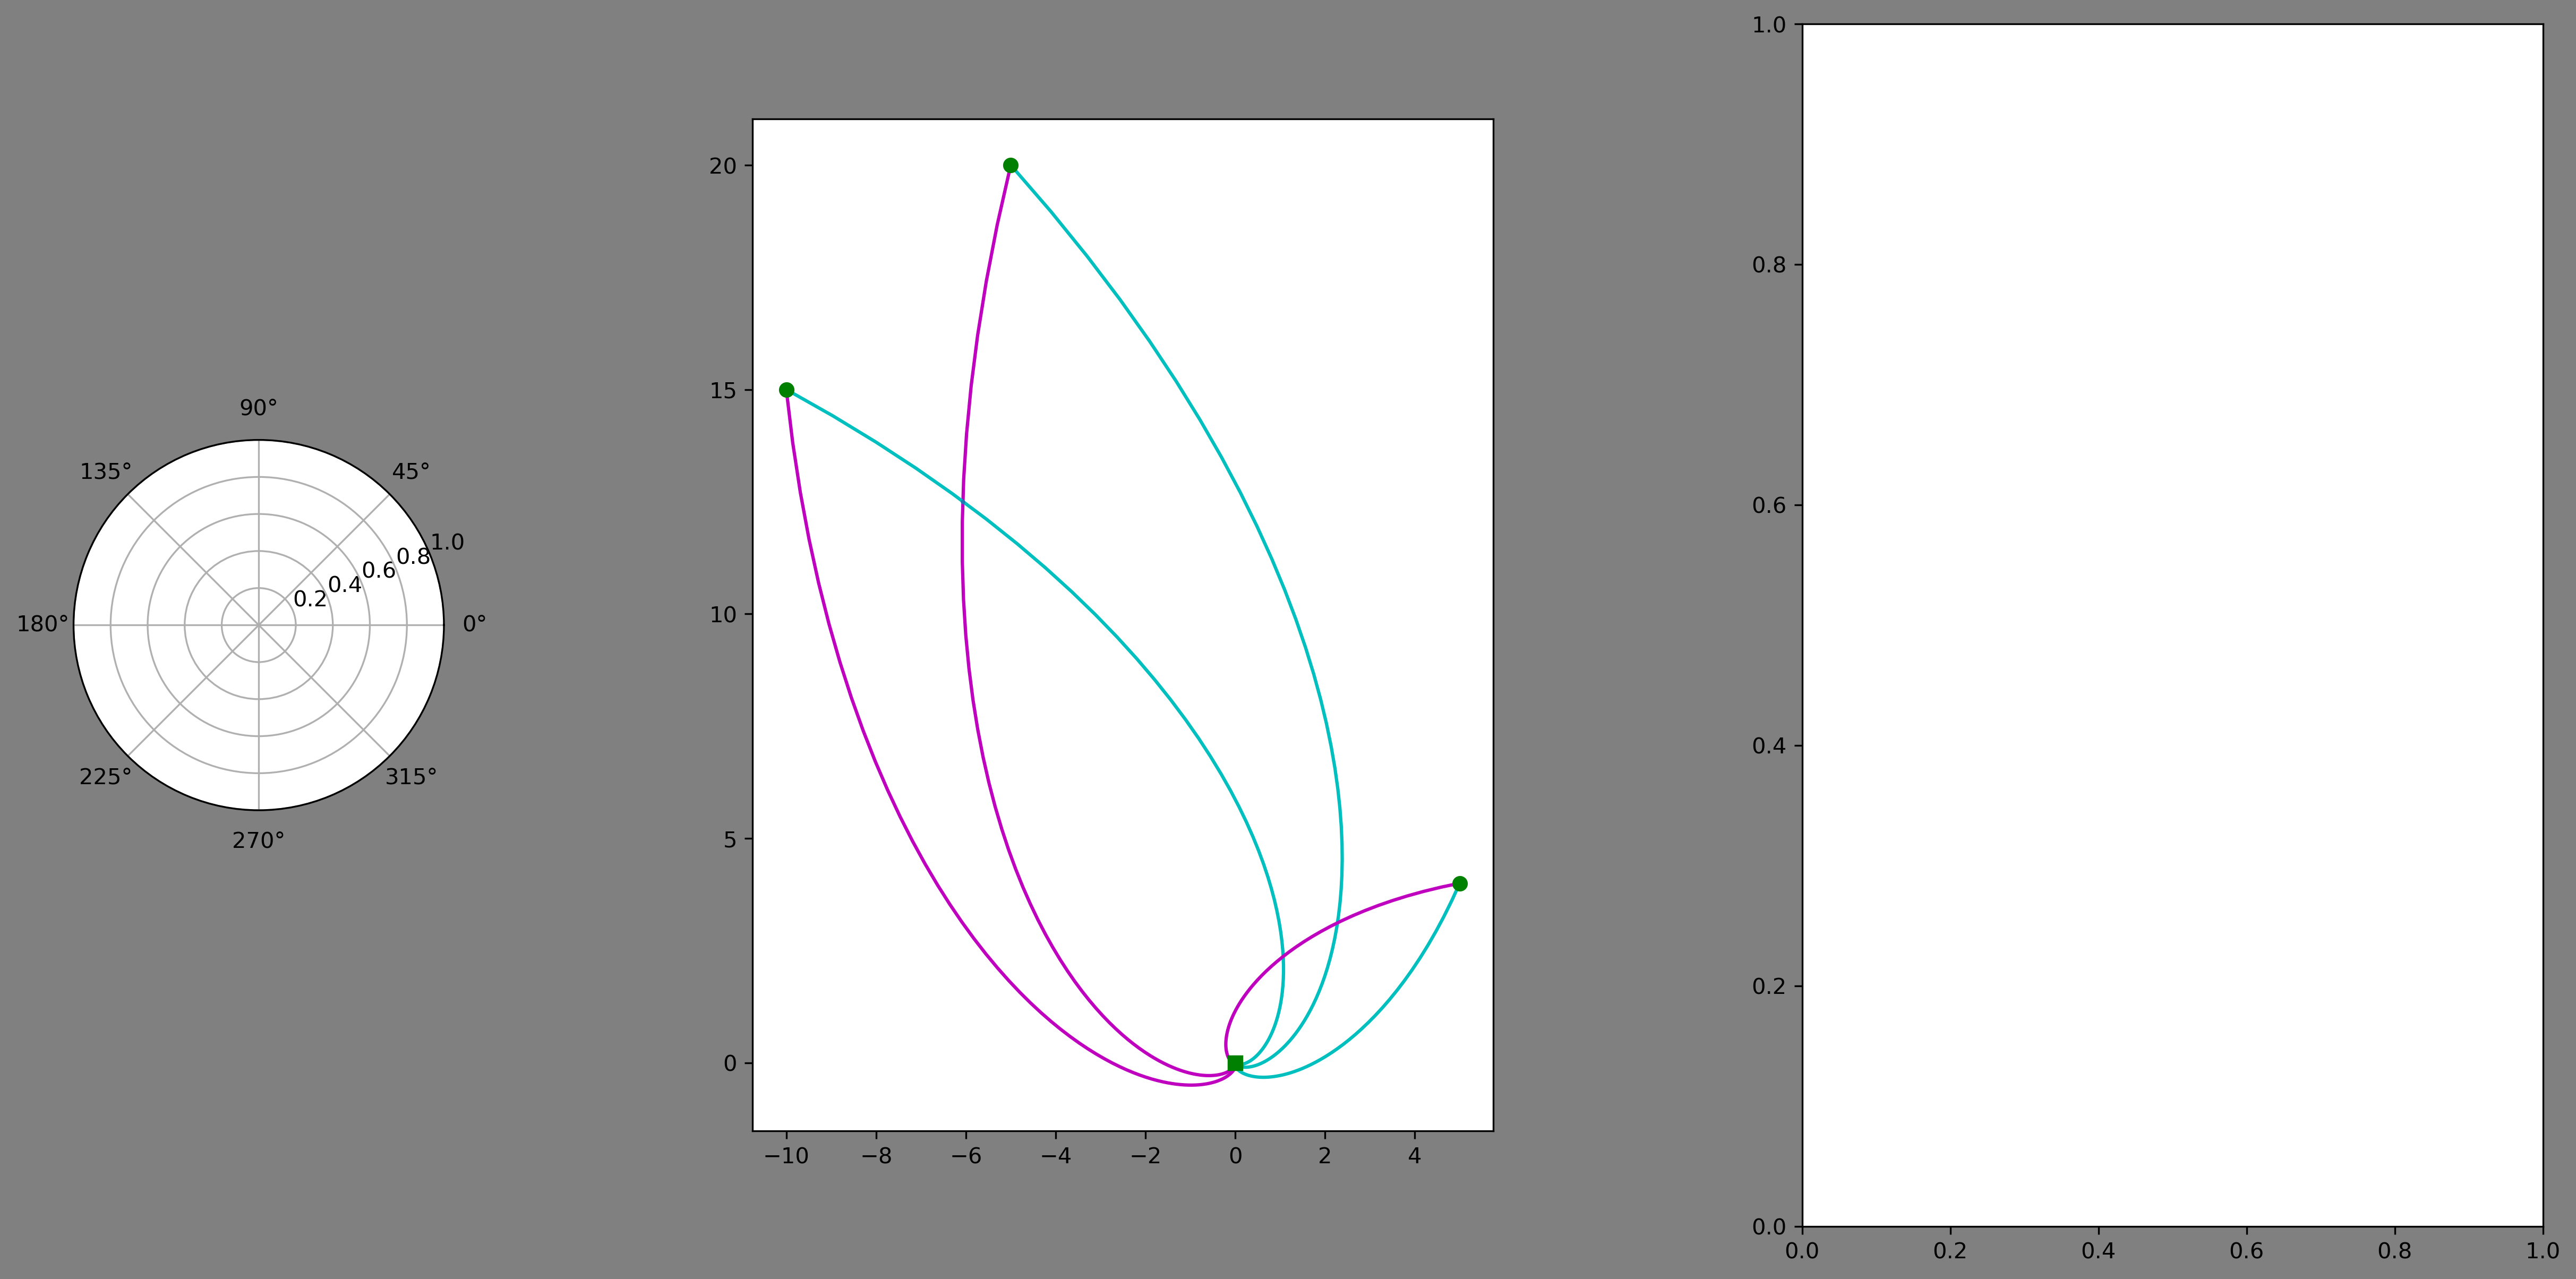

In [189]:
# тест работы LimitedSLC
fig = plt.figure(1,(20,10), facecolor='gray', dpi=300)
spec = gridspec.GridSpec(ncols=3, nrows=1,
                 width_ratios=[1, 2, 2], wspace=0.5,
                 hspace=0.5)
ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')
ax3 = fig.add_subplot(spec[2],polar=False, facecolor='white')

b=1.9
# curve = NodeRegion(b=b, root=(0,0), leaf=(17, -4))
# curve1 = NodeRegion(b=b, root=(0,0), leaf=(20, 7))

curve1 = NodeRegion(b=b, root=(0,0), leaf=(-10, 15))
curve = NodeRegion(b=b, root=(0,0), leaf=(-5, 20))
curve2 = NodeRegion(b=b, root=(0,0), leaf=(5, 4))

# curve = NodeRegion(b=b, root=(0,0), leaf=(17, -4))
# curve1 = NodeRegion(b=b, root=(0,0), leaf=(-8, -20))

# curve = NodeRegion(b=b, root=(0,0), leaf=(-178.2827001181997, 19.38941210325078))
# curve1 = NodeRegion(b=b, root=(0,0), leaf=(-154.36600909848062, -16.788315204785544))

curve.plot(ax1, ax2, False)
curve1.plot(ax1, ax2, False)
curve2.plot(ax1, ax2, False)

intr = intersect(curve, curve1)['position_type']
point_xy = intr[0]

ax2.plot(point_xy[0], point_xy[1], "o", markersize=1)

params_l, fake_uplim_l = curve.crop(intr[1],upperlimit_xy=intr[0])
params_r, fake_uplim_r = curve1.crop(rl_inverse(intr[1]),upperlimit_xy=intr[0])
fake_uplim = {
    'right': fake_uplim_r,
    'left': fake_uplim_l
}

# curve.tplot(ax1, ax3)
# curve1.tplot(ax1, ax3)



c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:119: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  inter_crds0 = np.array(LineString(intersection).coords)
C:\Users\Pinigin\anaconda3\envs\spat_a_course\lib\site-packages\shapely\geometry\linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
c:\Users\Pinigin\Documents\Ящик\Универ\_Диплом\spilay_flowtrees\local_utils.py:137: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  inter_crds1 = np.array(LineString(intersection).coords)


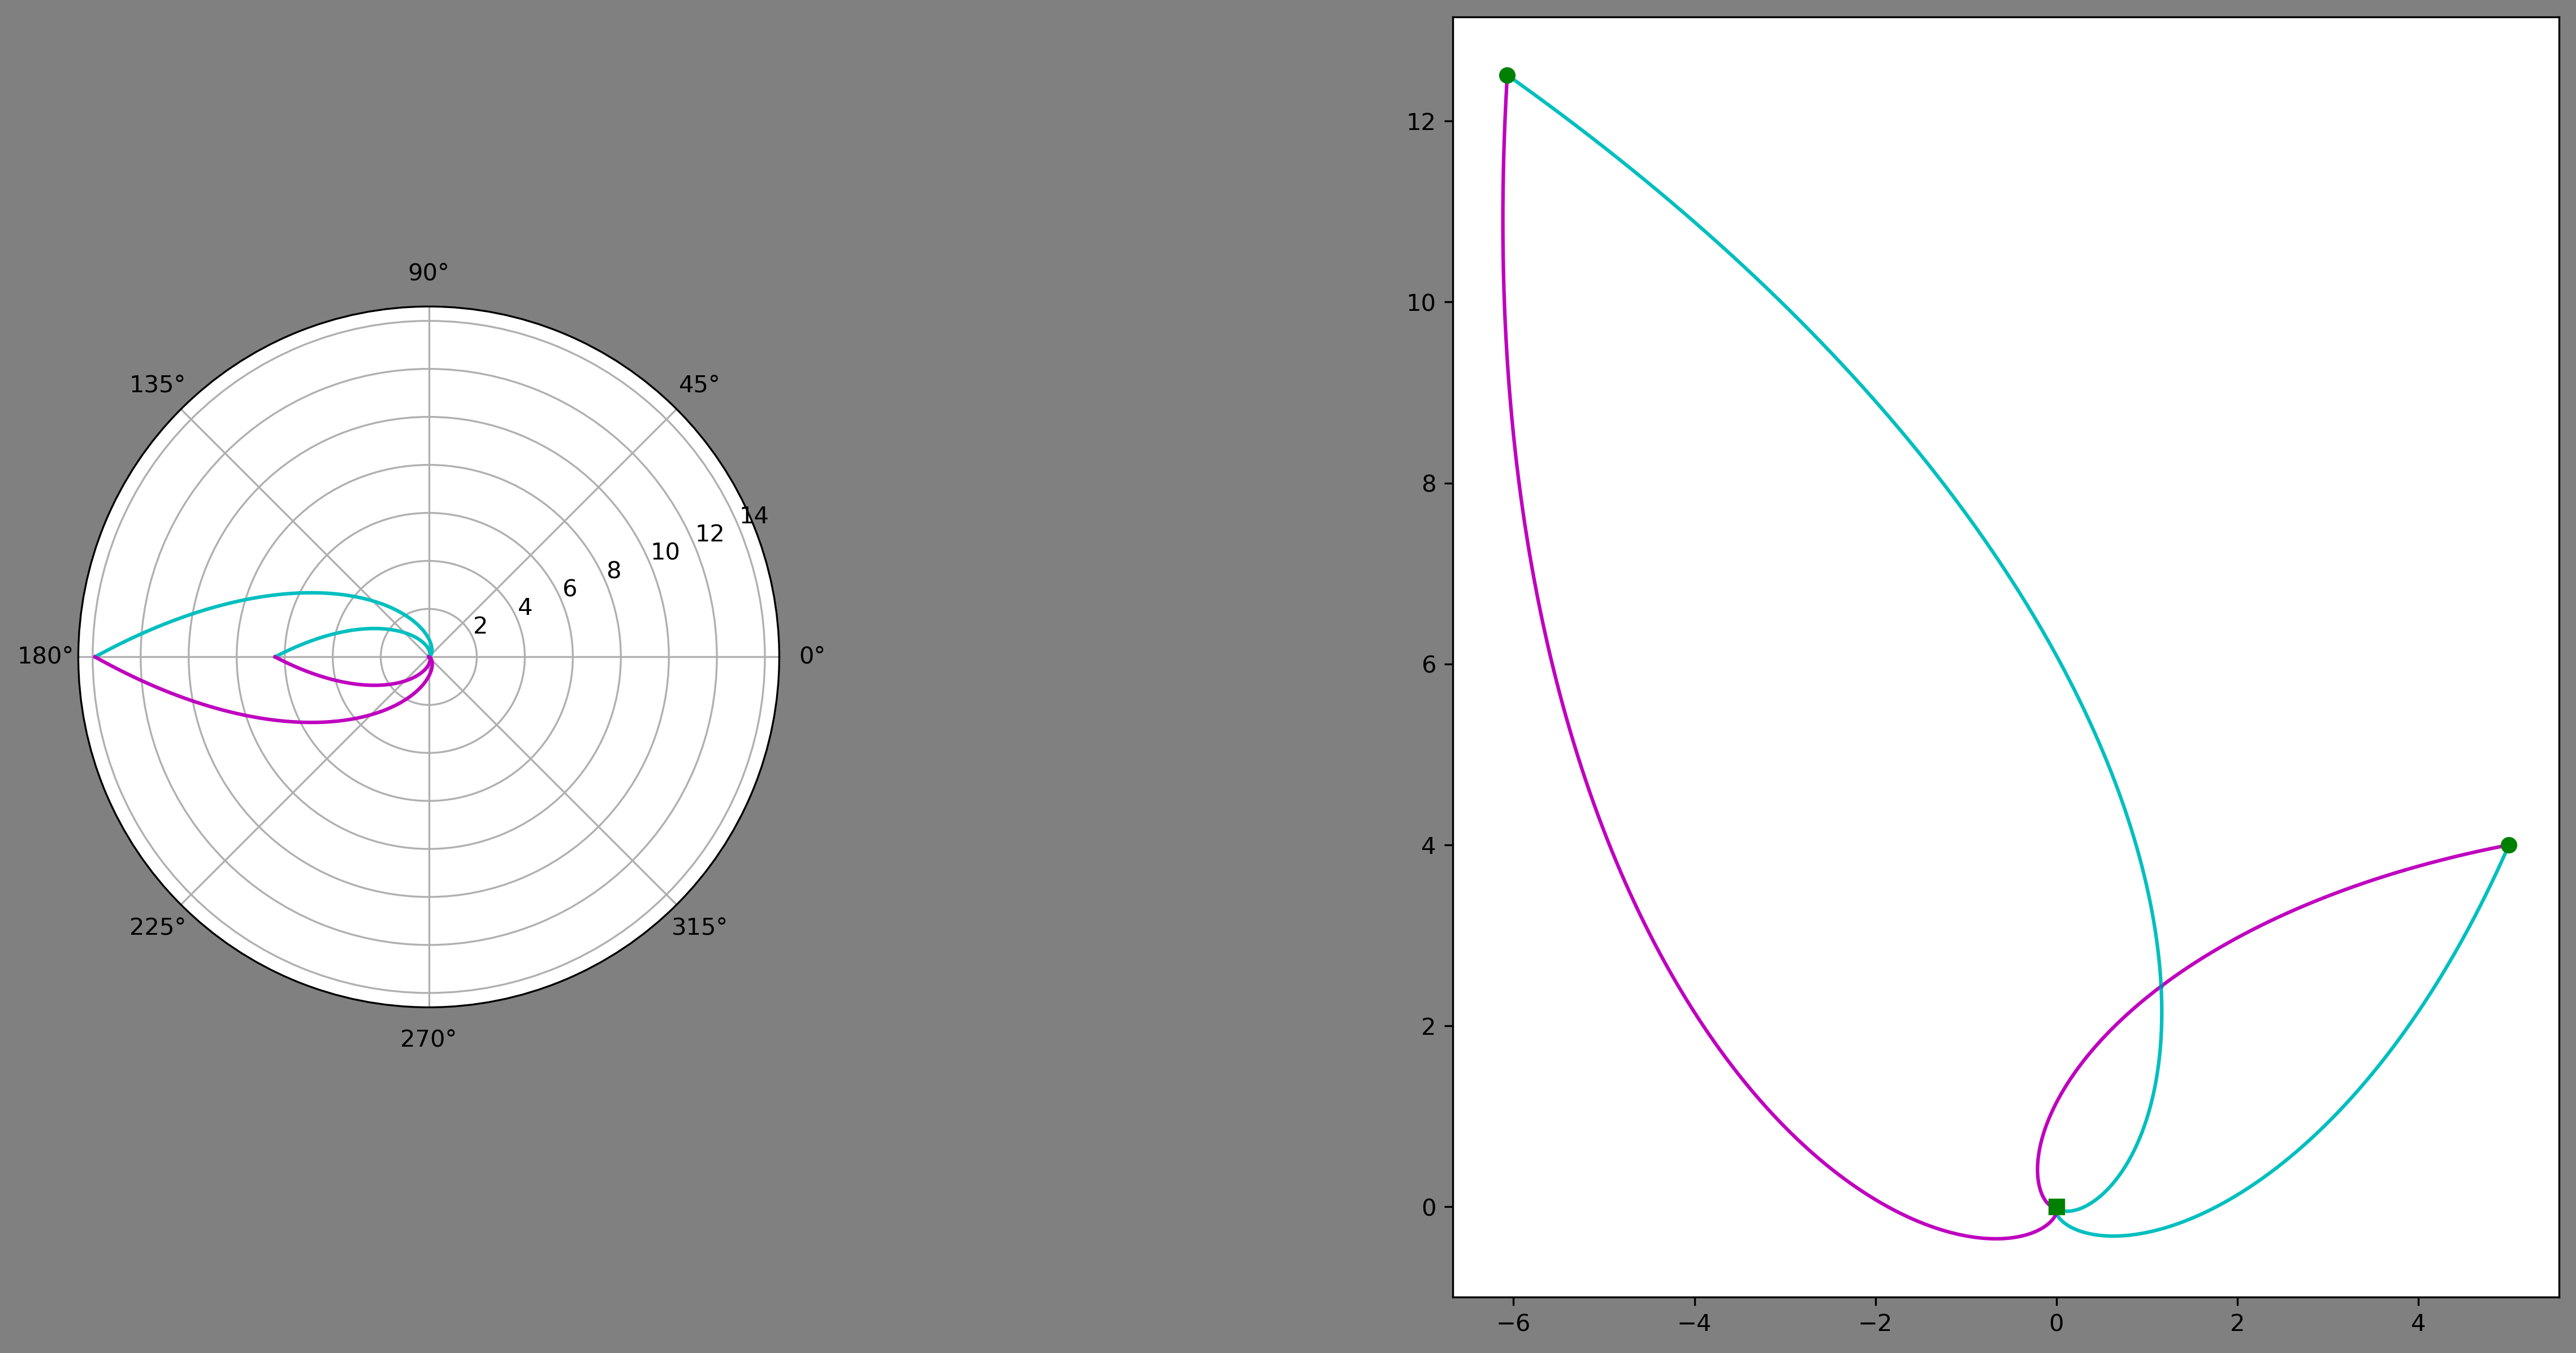

In [185]:
fig = plt.figure(1,(20,10), facecolor='gray', dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=1,
                 width_ratios=[1, 2], wspace=0.5,
                 hspace=0.5)
ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')

new_curve = NodeRegion(root=(0,0), leaf=tuple(point_xy.tolist()), params_l=params_l['left'], params_r=params_r['right'], fake_uplim=fake_uplim)

curve2.plot(ax1=ax1, ax2=ax2)
new_curve.plot(ax1=ax1, ax2=ax2)

intr = intersect(curve2, new_curve)['position_type']
point_xy2 = intr[0]

ax2.plot(point_xy2[0], point_xy2[1], "o", markersize=1)

params_l, fake_uplim_l = curve2.crop(intr[1],upperlimit_xy=intr[0])
params_r, fake_uplim_r = new_curve.crop(rl_inverse(intr[1]),upperlimit_xy=intr[0])
fake_uplim = {
    'right': fake_uplim_r,
    'left': fake_uplim_l
}

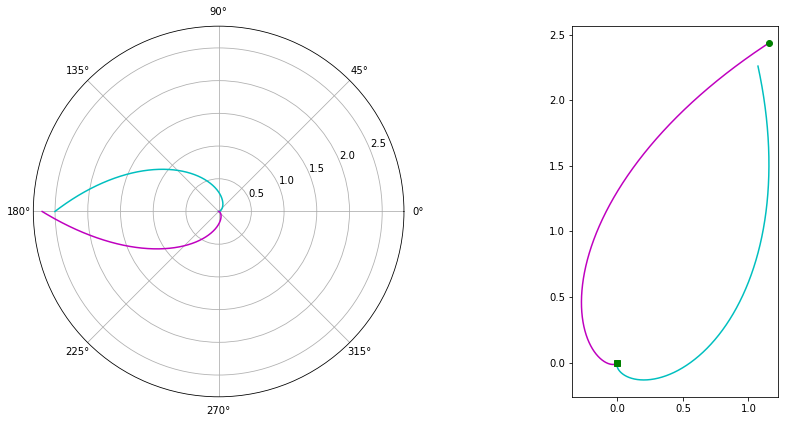

In [186]:
new_curve2 = NodeRegion(root=(0,0), leaf=tuple(point_xy2.tolist()), params_l=params_l['left'], params_r=params_r['right'], fake_uplim=fake_uplim)

new_curve2.plot()

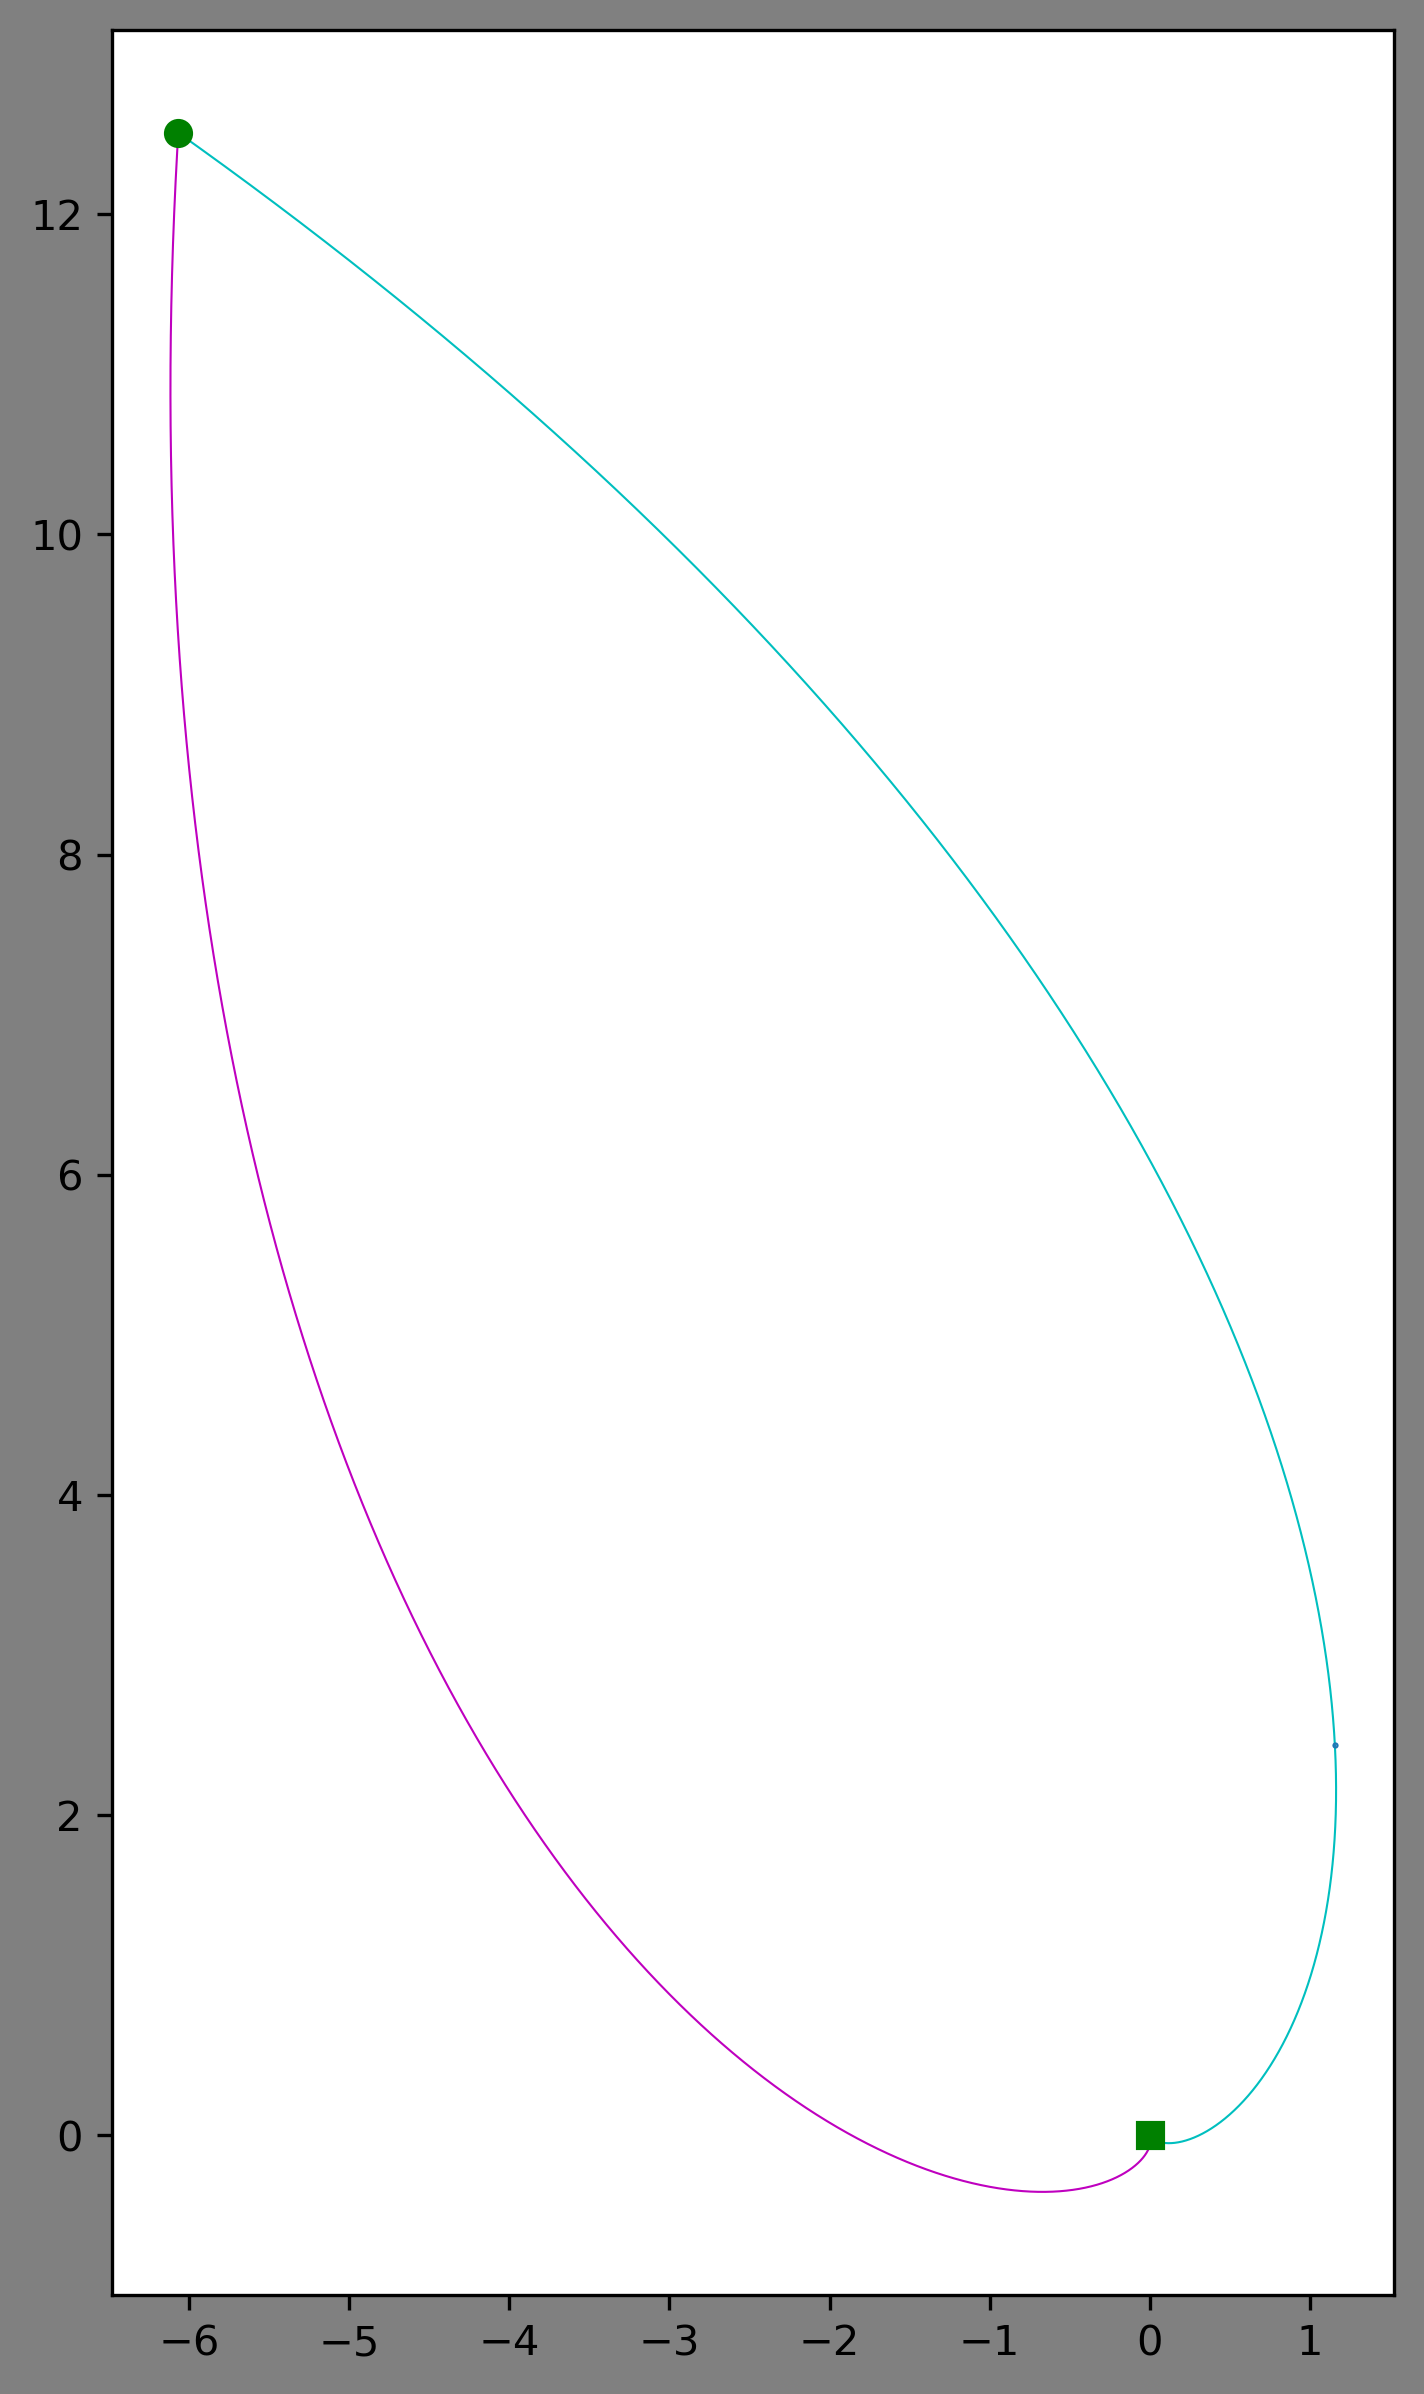

In [187]:
fig = plt.figure(1,(10,10), facecolor='gray', dpi=300)

ax2 = fig.add_subplot(polar=False, facecolor='white')



new_curve.plot(ax2=ax2, polar=False, linewidth=0.5)
ax2.plot(point_xy2[0], point_xy2[1], "o", markersize=0.5)

In [14]:
np.arctan2(point_xy[1], point_xy[0]) + np.pi*2, curve.ang

(3.1793414035485235, 3.0332618724315243)

{'curves': (<__main__.LimitedSLC at 0x28a458d7640>,
  <__main__.LimitedSLC at 0x28a458d76d0>),
 'position_type': (array([-135.58628037,   -5.12064508]), 'left'),
 'dst': 135.68294081995776}

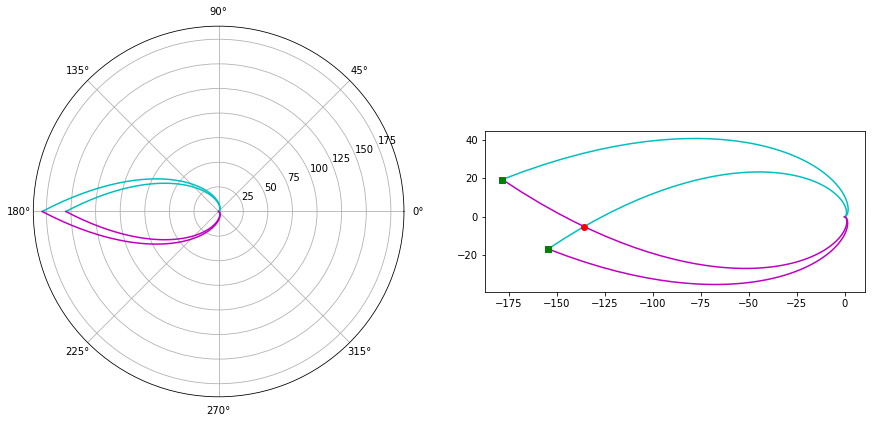

In [230]:
# тес работы intersect на двух кривых
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(-178.2827001181997, 19.38941210325078), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-154.36600909848062, -16.788315204785544), run=True)

# Пример отсутствия пересечений:
# curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(-10, 15), run=True)
# curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(-5, 5), run=True)

#th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve1, curve])
intersect(curve, curve1, True)

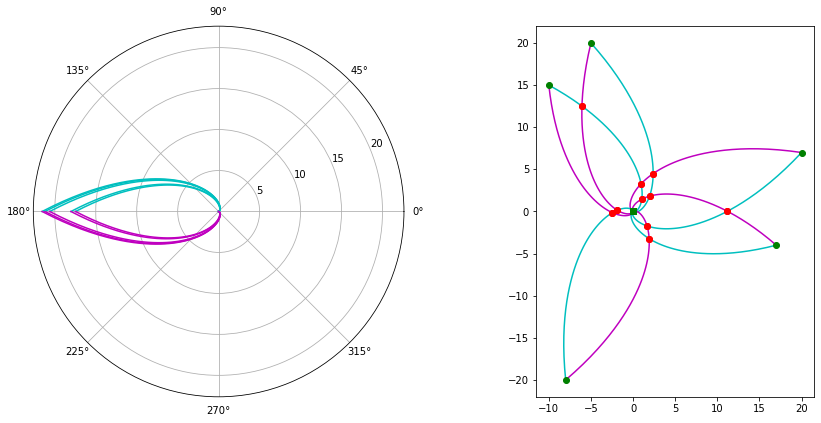

In [5]:
#тест работы intersect и draw на большом наборе
b = 1.9
curves = []
crd_tuple = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)
            # , (3,7)
            ]
for i in crd_tuple:
    curves.append(NodeRegion(b=b, root=(0,0), leaf=i))
draw(curves)
for i in curves:
    b = curves.copy()
    b.remove(i)
    for c in b:
        intersect(i, c, plotting=True)['position_type'][0]